<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>


<div><img src="https://www.ibm.com/blogs/bluemix/wp-content/uploads/2017/02/NLU.png", width=270, height=270, align = 'right'> 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# Extract Insights from Social Media with Watson Developer Cloud and Watson Studio

This notebook shows you how you can use the Watson APIs and Watson Studio to analyze and visualize data from social media to get customer insights. Brand managers can use this information to obtain enhanced insights about customer preferences enabling them to make more accurate marketing decisions. For a more detailed description of the problem solved, solution architecture, data collection and creating/accessing the services involved, please consult <a href="https://www.ibm.com/developerworks/library/cc-cognitive-watson-extract-insights-spark-dsx/index.html" target="_blank" rel="noopener no referrer">this tutorial</a>.

This notebook runs on Python and Spark.
___________

## Table of contents

1.  [Load the required libraries](#loadlibraries)
2.  [Load data from Db2 Warehouse on Cloud](#loaddata)
3.  [Perform some exploratory data analysis](#exploredata)
4.  [Take a data sample](#takesample)
5.  [Read credentials for NLU, Personality Insights, and Twitter](#getcredentials)
6.  [Enrich the data with Watson NLU](#enrichnlu)
7.  [Visualize sentiment and keywords](#sentiment)
8.  [Enrich data with Watson Personality Insights](#enrichpi)
9.  [Spark machine learning for user segmentation](#sparkml)
10. [Visualize user segmentation](#clusters)

__________________

<a id="loadlibraries"></a>
## Step 1: Load the required libraries

- <a href="https://github.com/watson-developer-cloud/python-sdk" target="_blank" rel="noopener no referrer">watson-developer-cloud</a> is the Python SDK for Watson Developer Cloud services 

- <a href="http://www.tweepy.org/" target="_blank" rel="noopener no referrer">tweepy</a> is a Python library for accessing Twitter API

- <a href="https://github.com/amueller/word_cloud/" target="_blank" rel="noopener no referrer">wordcloud</a> is a Python library for generating Word Clouds 

- <a href="https://pypi.python.org/pypi/plotly" target="_blank" rel="noopener no referrer">plotly</a> is a Python library for making plots and charts

In [ ]:
!pip install --upgrade watson-developer-cloud==1.0.2
!pip install tweepy==3.3.0 --upgrade --force-reinstall
!pip install --upgrade plotly
!pip install --upgrade --force-reinstall wordcloud

________________

<a id="loaddata"> </a>
## Step 2: Load data from Db2 Warehouse on Cloud

The first step is to load the data. This notebook assumes you have tweets already in a Db2 Warehouse on Cloud database. For more details about how to collect relevant tweets into a Db2 Warehouse on Cloud database, check out <a href="https://github.com/joe4k/twitterstreams" target="_blank" rel="noopener no referrer">this</a> github repository.

If you already know <a href="https://dataplatform.ibm.com/docs/content/manage-data/create-conn.html?audience=cloud&context=analytics" target="_blank" rel="noopener no referrer">how to create a data connection</a>, you can skip this step.

To create a new connection in a project:

1. Navigate to your project.
2. Click **Add to project > Connections**.
3. From the list of **Your service instances on IBM Cloud**, select the Db2 Warehouse instance that contains the tweets to analyze (Note that you can create a connection to other IBM or Third-party services as well).
4. Provide a connection name, in this case `dashdbsingers`.
5. Select **BLUDB** database and press **Create**. The connection appears on the **Assets** page.

Lastly, you need to add code to your notebook to read the data from your Db2 Warehouse instance.
1. Create a new cell in your notebook.
2. Click the **Data** icon.
3. Click the **Connections** tab.
4. Find `dashdbsingers` connection, then click **Insert to code** under `dashdbsingers` connection.
5. Select **Insert SparkSession DataFrame**.
6. Select the correct SCHEMA and TABLE to access your data (in our example, SCHEMA is **DASH6296** and TABLE is **DSX_CLOUDANT_SINGERS_TWEETS**).
This adds code into the notebook to load data from Db2 Warehouse instancedatabase. 

**Note:** You would select a specific table to load. In this  case, you load **DSX_CLOUDANT_SINGERS_TWEETS**.

In [2]:
# This cell is where code is inserted to load data from your dashDB instance with tweets to analyze.


Row(COORDINATES_TYPE=None, CREATED_AT=u'Wed Jul 12 16:40:03 +0000 2017', FAVORITE_COUNT=0, ID=885176943708172289, LANG=u'en', PLACE_BOUNDING_BOX_TYPE=u'FeatureCollection', PLACE_COUNTRY=u'Brasil', PLACE_COUNTRY_CODE=u'BR', PLACE_FULL_NAME=u'Rio de Janeiro, Brasil', PLACE_ID=u'97bcdfca1a2dca59', PLACE_NAME=u'Rio de Janeiro', PLACE_PLACE_TYPE=u'city', PLACE_URL=u'https://api.twitter.com/1.1/geo/id/97bcdfca1a2dca59.json', TEXT=u'"God is good in the midst of darkness in the midst of evil God is in the midst" https://t.co/PKPUELjebb', TEXT_CLEAN=u'"God is good in the midst of darkness in the midst of evil God is in the midst" ', USER_FAVOURITES_COUNT=39491, USER_FOLLOWERS_COUNT=574, USER_FRIENDS_COUNT=60, USER_ID=2976366257, USER_LOCATION=None, USER_SCREEN_NAME=u'kewenjanuario', USER_STATUSES_COUNT=8994, _ID=u'7dbc74fef87624c1998668f371f43212', _REV=u'1-e1f8d34b750dadf07768074525b0d6af')

In [3]:
# copy data into brandTweetsDF dataframe for processing
brandTweetsDF = data_df_3

___________

<a id="exploredata"> </a>
## Step 3: Run some exploratory data analysis

In [4]:
# Return top 2 rows of Spark DataFrame
brandTweetsDF.limit(2).toPandas()

,COORDINATES_TYPE,CREATED_AT,FAVORITE_COUNT,ID,LANG,PLACE_BOUNDING_BOX_TYPE,PLACE_COUNTRY,PLACE_COUNTRY_CODE,PLACE_FULL_NAME,PLACE_ID,...,TEXT_CLEAN,USER_FAVOURITES_COUNT,USER_FOLLOWERS_COUNT,USER_FRIENDS_COUNT,USER_ID,USER_LOCATION,USER_SCREEN_NAME,USER_STATUSES_COUNT,_ID,_REV
0,None,Fri Jul 07 19:05:19 +0000 2017,0,883401558540431360,en,None,None,None,None,None,...,Because your boyfriend is a girlfriend,5,7,35,29899524,43112,btkb8,2,93b64fff28cb8ce9a9a0be5b5232af43,1-feb69621bcb84206c30850a4476f58d8
1,None,Fri Jul 07 19:53:22 +0000 2017,0,883413654623924224,en,None,None,None,None,None,...,RT : Cover of 2U by @JustinBieber with out no...,18796,1232,1628,724153524,Rochester NY,baileywarax,35837,96dbe27e075a33bdd085344ce0ee4f99,1-1f820cd5dee98e1a50e86dcbebd92609


In [5]:
# Print the schema of the loaded data
brandTweetsDF.printSchema()

root
 |-- COORDINATES_TYPE: string (nullable = true)
 |-- CREATED_AT: string (nullable = true)
 |-- FAVORITE_COUNT: long (nullable = true)
 |-- ID: long (nullable = true)
 |-- LANG: string (nullable = true)
 |-- PLACE_BOUNDING_BOX_TYPE: string (nullable = true)
 |-- PLACE_COUNTRY: string (nullable = true)
 |-- PLACE_COUNTRY_CODE: string (nullable = true)
 |-- PLACE_FULL_NAME: string (nullable = true)
 |-- PLACE_ID: string (nullable = true)
 |-- PLACE_NAME: string (nullable = true)
 |-- PLACE_PLACE_TYPE: string (nullable = true)
 |-- PLACE_URL: string (nullable = true)
 |-- TEXT: string (nullable = true)
 |-- TEXT_CLEAN: string (nullable = true)
 |-- USER_FAVOURITES_COUNT: long (nullable = true)
 |-- USER_FOLLOWERS_COUNT: long (nullable = true)
 |-- USER_FRIENDS_COUNT: long (nullable = true)
 |-- USER_ID: long (nullable = true)
 |-- USER_LOCATION: string (nullable = true)
 |-- USER_SCREEN_NAME: string (nullable = true)
 |-- USER_STATUSES_COUNT: long (nullable = true)
 |-- _ID: string (n

In [6]:
## Drop unneeded columns
brandTweetsDF = brandTweetsDF.drop('_ID','_REV')

Extract day from the `CREATED_AT` field. This is useful to plot tweet trends over time.

In [7]:
import datetime
from datetime import date
from dateutil import parser

def getDay(date):
    print 'input date: ', date
    day = parser.parse(str(date))
    day = day.date()
    return day

# Add a field for the day the tweet was created (ignoring hour/minute/second)
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType

udfGetDay = udf(getDay, DateType())

brandTweetsDF = brandTweetsDF.withColumn('DAY',udfGetDay('CREATED_AT'))

# Verify added field is as expected
brandTweetsDF.select("DAY").limit(5).toPandas()

,DAY
0,2017-07-05
1,2017-07-05
2,2017-07-05
3,2017-07-05
4,2017-07-05


____________

<a id="takesample"> </a>
## Step 4: Take a data sample
For purposes of this tutorial, we will work with a small sample of the data. In practice, you want to use large data sets for our analysis to capture as many insights as we can. However, to illustrate the approach, we can work with a small data set.

Furthermore, we want to restrict the number of API calls to the free plan of <a href="https://www.ibm.com/watson/developercloud/" target="_blank" rel="noopener no referrer">Watson Developer Cloud</a> services so users can run through the notebook successfully even if they only have access to free tier of the services.

In [8]:
## Take a sample of the data
## Limit to 1000 records as Watson NLU allows 1000 free calls per day
import random

num_records = brandTweetsDF.count()
sample_num_records = 950
fraction = float(sample_num_records)/float(num_records)

seed = random.randint(1, 100)
print 'Number of records: ', num_records, ' Sample size: ', sample_num_records, ' Fraction: ', fraction, ' Seed: ', seed
brandTweetsSampleDF = brandTweetsDF.sample(False, fraction, seed)


## Alternative Stratified Sampling approach
## Returns RDD with length of 2, first col is the key (day) and second col is the original row for the key
## Take only the actual data (column 1)
## If you'd like to use this approach, uncomment the following 4 lines

#fractionList = brandTweetsDF.rdd.map(lambda x: x['DAY']).distinct().map(lambda x: (x,fraction)).collectAsMap()
#keybyday = brandTweetsDF.rdd.keyBy(lambda x: x['DAY'])
#brandTweetsDFrdd = keybyday.sampleByKey(False,fractionList).map(lambda x: x[1])
#brandTweetsSampleDF = spark.createDataFrame(brandTweetsDFrdd,brandTweetsDF.schema)


print 'Number of records to send to NLU:', brandTweetsSampleDF.count()

Number of records:  198070  Sample size:  950  Fraction:  0.00479628414197  Seed:  81
Number of records to send to NLU: 956


In [9]:
# plot number of tweets per day
from pyspark.sql import functions as F
brandTweetsSampleDFperDay = brandTweetsSampleDF.groupBy('DAY')\
                              .agg(F.count('ID')\
                              .alias('NUM_TWEETS_PER_DAY'))
brandTweetsSampleDFperDay.show()

+----------+------------------+
|       DAY|NUM_TWEETS_PER_DAY|
+----------+------------------+
|2017-07-06|               126|
|2017-07-10|               148|
|2017-07-11|                69|
|2017-07-12|                59|
|2017-07-09|               203|
|2017-07-05|                31|
|2017-07-07|               136|
|2017-07-13|                55|
|2017-07-08|               129|
+----------+------------------+



____________

<a id="getcredentials"> </a>
## Step 5: Read the credentials for NLU, Personality Insights, and Twitter
Upload a json file (for example, `sample_creds.json`) which has the credentials for NLU, Personality Insights and Twitter to your Object Storage instance.


1. From your notebook, click the **Data** icon. 
2. Click **Files** tab.
3. Either drop your file in the box or click **browse** to select the file with credentials information from your local disk.
4. After you have selected the file, press **Open** to upload the file to object storage.
Here is the format for the credentials file:
```
{
	"nlu_username": "YOUR NLU username",
	"nlu_password": "YOUR NLU password",
	"nlu_version": "NLU version",
	"twitter_consumer_key": "YOUR Twitter App consumer key",
	"twitter_consumer_secret": "YOUR Twitter App consumer secret",
	"twitter_access_token": "YOUR Twitter App access token",
	"twitter_access_token_secret": "YOUR Twitter App access token secret",
	"pi_username": "YOUR Personality Insights username",
	"pi_password": "YOUR Personality Insights password",
	"pi_version": "Personality Insights version"
}
```
After the file has been uploaded, you should see the `sample_creds.json` file under **Files** tab under the **Data** column.

Next, read the `sample_creds.json` credentials file and set the credentials for NLU, Personality Insights, and Twitter.
1. Create a new cell in your notebook.
2. If not open, click the **Data** icon.
3. Click the **Files** tab.
4. Find the ```sample_creds.json``` file and click **Insert to code** under the file name 
5. Choose **Insert Credentials**. This inserts code into your notebook for setting the credentials to read that file from object storage.

In [10]:
## Read credentials for NLU, Personality Insights, and Twitter from sample_creds.json
## This cell gets populated with inserted code for reading sample_creds.json file from your Object Storage instance
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.

In [11]:
import json
from botocore.client import Config
import ibm_boto3

In [12]:
# copy credentials into generic variable
credentials_os = credentials_5

# Define cloud object storage client
client = ibm_boto3.client(
    service_name = 's3', 
    ibm_api_key_id = credentials_os['IBM_API_KEY_ID'],
    ibm_auth_endpoint = credentials_os['IBM_AUTH_ENDPOINT'],
    config = Config(signature_version = 'oauth'),
    endpoint_url = credentials_os['ENDPOINT']
)



In [13]:
cosfile= client.get_object(Bucket = credentials_os['BUCKET'], Key=credentials_os['FILE'])['Body']
credentials_json = json.loads(cosfile.read())
# If you'd like to print to verify credentials, uncomment the line below
# print(json.dumps(credentials_json,indent=2))

__________

<a id="enrichnlu"> </a>
## Step 6: Enrich the data with  <a href="https://www.ibm.com/watson/developercloud/natural-language-understanding.html" target="_blank" rel="noopener no referrer">Watson Natural Language Understanding (NLU)</a>

Watson NLU allows us to extract sentiment and keywords from text.  In our case, the text is user tweets.

In [14]:
import watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions, KeywordsOptions
from watson_developer_cloud import WatsonException


## Define credentials for NLU service
nlu_username=credentials_json['nlu_username']
nlu_password=credentials_json['nlu_password']
nlu_version=credentials_json['nlu_version']
nlu = watson_developer_cloud.NaturalLanguageUnderstandingV1(version = nlu_version,
                                                            username = nlu_username,
                                                            password = nlu_password)

## Send text to NLU and extract Sentiment and Keywords
## Make sure text is utf-8 encoded
def enrichNLU(text):
    utf8text = text.encode("utf-8")
    # In python3, need to decode to string
    utf8text = utf8text.decode('utf-8')
    
    try:
        result = nlu.analyze(text = utf8text, features = Features(sentiment=SentimentOptions(),keywords=KeywordsOptions()))
        sentiment = result['sentiment']['document']['score']
        sentiment_label = result['sentiment']['document']['label']
        keywords = list(result['keywords'])  
    except WatsonException:
        result = None
        sentiment = 0.0
        sentiment_label = None
        keywords = None
    return sentiment, sentiment_label, keywords

We'll convert our dataframe to a Pandas dataframe and enrich the tweets with the results of Watson NLU.

In [15]:
# Create a Pandas frame and augment with Sentiment analysis and Keywords using Watson NLU
brandTweetsSamplePandasDF = brandTweetsSampleDF.toPandas()

**The next cell sends the records to the Watson API, so be aware of the number of calls that are being made. If you are on the free plan which is limited to 1000 API calls per day, you can only run this cell once. After that the server responds with a notice indicating you have reached the maximum number of API calls for the day.**  This could take 60+ seconds so some patience is required.  

In [16]:
## This calls the enrichNLU function which accesses the Watson NLU API
brandTweetsSamplePandasDF['SENTIMENT'],brandTweetsSamplePandasDF['SENTIMENT_LABEL'],\
brandTweetsSamplePandasDF['KEYWORDS'] = zip(*brandTweetsSamplePandasDF['TEXT_CLEAN'].map(enrichNLU))

In [17]:
# view top two records to verify Sentiment and Keywords enrichments are applied as expected
print 'Rows x Columns for brandTweetsSampleDF:', brandTweetsSamplePandasDF.shape
brandTweetsSamplePandasDF[:10] 

Rows x Columns for brandTweetsSampleDF: (956, 26)


COORDINATES_TYPE                      CREATED_AT  FAVORITE_COUNT  \
0             None  Fri Jul 07 20:02:50 +0000 2017               0   
1             None  Fri Jul 07 19:35:43 +0000 2017               0   
2             None  Fri Jul 07 19:09:40 +0000 2017               0   
3             None  Fri Jul 07 19:22:39 +0000 2017               0   
4             None  Fri Jul 07 21:37:54 +0000 2017               0   
5             None  Fri Jul 07 21:39:04 +0000 2017               0   
6             None  Fri Jul 07 22:25:44 +0000 2017               0   
7             None  Fri Jul 07 21:17:10 +0000 2017               0   
8             None  Fri Jul 07 21:23:08 +0000 2017               0   
9             None  Fri Jul 07 22:09:37 +0000 2017               0   

                   ID LANG PLACE_BOUNDING_BOX_TYPE PLACE_COUNTRY  \
0  883416033020739585   en                    None          None   
1  883409211211878402   en                    None          None   
2  883402653610287105   en                    None          None   
3  883405921841324032   en                    None          None   
4  883439958824013824   en                    None          None   
5  883440251238273025   en                    None          None   
6  883451995096526850   en                    None          None   
7  883434743152422912   en                    None          None   
8  883436244537139200   en                    None          None   
9  883447940576157697   en                    None          None   

  PLACE_COUNTRY_CODE PLACE_FULL_NAME PLACE_ID  \
0               None            None     None   
1               None            None     None   
2               None            None     None   
3               None            None     None   
4               None            None     None   
5               None            None     None   
6               None            None     None   
7               None            None     None   
8               None            None     None   
9               None            None     None   

                         ...                         USER_FOLLOWERS_COUNT  \
0                        ...                                          513   
1                        ...                                          245   
2                        ...                                            1   
3                        ...                                            8   
4                        ...                                         1748   
5                        ...                                          176   
6                        ...                                          147   
7                        ...                                           71   
8                        ...                                         1225   
9                        ...                                         1654   

  USER_FRIENDS_COUNT             USER_ID              USER_LOCATION  \
0                346          2496991541                         UK   
1                143  732293484934234112                       None   
2                 17  877606063452938240                       None   
3                 42  800026085601574912                 Irvine, CA   
4                522           219296729  Rio Grande do Sul, Brasil   
5                162           151550094    Somewhere Low, Building   
6                568  808113413654192128                       Iraq   
7                210  798126735246102529                       None   
8               2093          4905622761       carat & monbebe land   
9               1199           182033158        Tucumán - Argentina   

  USER_SCREEN_NAME  USER_STATUSES_COUNT         DAY  SENTIMENT  \
0    HypedFlatline                13339  2017-07-07   0.000000   
1     TassierLuana                10631  2017-07-07   0.000000   
2  Michell22729015                  228  2017-07-07   0.489563   
3     zarashirwany                   78  2017-07

In [18]:
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField

schema = brandTweetsSampleDF.schema
schema1 = StructType([
    StructField("relevance", FloatType(), True),
    StructField("text", StringType(), True),                            
])

keywordschema = StructType.fromJson(schema1.jsonValue())
added_fields = [StructField("SENTIMENT", FloatType(), True),StructField("SENTIMENT_LABEL",StringType(),True),\
                StructField("KEYWORDS",ArrayType(keywordschema),True)] 

newfields = StructType(schema.fields + added_fields)

In [19]:
## Push the enriched data back out to Spark to continue working within the Spark API
enrichedBrandTweetsDF = spark.createDataFrame(brandTweetsSamplePandasDF,newfields)

# Print the schema of the Spark DataFrame to verify we have all the expected fields
enrichedBrandTweetsDF.printSchema()

root
 |-- COORDINATES_TYPE: string (nullable = true)
 |-- CREATED_AT: string (nullable = true)
 |-- FAVORITE_COUNT: long (nullable = true)
 |-- ID: long (nullable = true)
 |-- LANG: string (nullable = true)
 |-- PLACE_BOUNDING_BOX_TYPE: string (nullable = true)
 |-- PLACE_COUNTRY: string (nullable = true)
 |-- PLACE_COUNTRY_CODE: string (nullable = true)
 |-- PLACE_FULL_NAME: string (nullable = true)
 |-- PLACE_ID: string (nullable = true)
 |-- PLACE_NAME: string (nullable = true)
 |-- PLACE_PLACE_TYPE: string (nullable = true)
 |-- PLACE_URL: string (nullable = true)
 |-- TEXT: string (nullable = true)
 |-- TEXT_CLEAN: string (nullable = true)
 |-- USER_FAVOURITES_COUNT: long (nullable = true)
 |-- USER_FOLLOWERS_COUNT: long (nullable = true)
 |-- USER_FRIENDS_COUNT: long (nullable = true)
 |-- USER_ID: long (nullable = true)
 |-- USER_LOCATION: string (nullable = true)
 |-- USER_SCREEN_NAME: string (nullable = true)
 |-- USER_STATUSES_COUNT: long (nullable = true)
 |-- DAY: date (nul

____________

<a id="sentiment"> </a>
## Step 7: Visualize sentiment and keywords

Twitter trends, sentiment, and keywords give a brand manager a view of a consumers' perceptions about the brand. These insights can be very useful to the brand manager. 

In this step we visualize some of the data we received from NLU. Let's look at tweet trends and sentiment for **katyperry** and **taylorswift**. In addition, let's show the main keywords tweeted for both musicians.

In this section:<br/>
7.1 [Compare sentiment between brand1, brand2 and brand3](#compare)<br/>
7.2 [View sentiment over time for brands](#view)<br/>
7.3 [Top keywords](#keywords)



In [20]:
# Separate tweets by brand
# To do so, check if the tweet includes which brand and add a column to represent that
brandList=['katyperry','justinbieber','taylorswift']
def addBrand(text):
    for brand in brandList:
        if brand in text.lower():
            return brand
    return None

In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

udfAddBrand = udf(addBrand, StringType())

# For purposes of separating tweets by brand, we need to run it against original TEXT and not the TEXT_CLEAN
# This is because in several cases, the brand is referenced with a handle
enrichedBrandsDF = enrichedBrandTweetsDF.withColumn('BRAND',udfAddBrand('TEXT'))

# view top records to verify brand column extracted as expected
enrichedBrandsDF.limit(2).toPandas()

,COORDINATES_TYPE,CREATED_AT,FAVORITE_COUNT,ID,LANG,PLACE_BOUNDING_BOX_TYPE,PLACE_COUNTRY,PLACE_COUNTRY_CODE,PLACE_FULL_NAME,PLACE_ID,...,USER_FRIENDS_COUNT,USER_ID,USER_LOCATION,USER_SCREEN_NAME,USER_STATUSES_COUNT,DAY,SENTIMENT,SENTIMENT_LABEL,KEYWORDS,BRAND
0,None,Fri Jul 07 20:02:50 +0000 2017,0,883416033020739585,en,None,None,None,None,None,...,346,2496991541,UK,HypedFlatline,13339,2017-07-07,0,neutral,"[(0.747349023819, stays), (0.688778996468, bow)]",None
1,None,Fri Jul 07 19:35:43 +0000 2017,0,883409211211878402,en,None,None,None,None,None,...,143,732293484934234112,None,TassierLuana,10631,2017-07-07,0,neutral,"[(0.914162993431, votes), (0.591068029404, awa...",justinbieber



To visualize the difference in sentiment between brands, we'll create a separate dataframe for each brand.


In [22]:
from pyspark.sql.functions import col

## Create one DF for katyperry, one for taylorswift
brand1TweetsDF = enrichedBrandsDF.where(col('BRAND') == 'katyperry')
brand2TweetsDF = enrichedBrandsDF.where(col('BRAND') == 'justinbieber')
brand3TweetsDF = enrichedBrandsDF.where(col('BRAND') == 'taylorswift')


In [23]:
# Print out number of tweets for each brand in our sample
print "Number of tweets for katyperry: ", brand1TweetsDF.count()
print "Number of tweets for justinbieber: ", brand2TweetsDF.count()
print "Number of tweets for taylorswift: ", brand3TweetsDF.count()


Number of tweets for katyperry:  136
Number of tweets for justinbieber:  688
Number of tweets for taylorswift:  76


In [24]:
brand1TweetsDF.head(2)

[Row(COORDINATES_TYPE=None, CREATED_AT=u'Fri Jul 07 19:22:39 +0000 2017', FAVORITE_COUNT=0, ID=883405921841324032, LANG=u'en', PLACE_BOUNDING_BOX_TYPE=None, PLACE_COUNTRY=None, PLACE_COUNTRY_CODE=None, PLACE_FULL_NAME=None, PLACE_ID=None, PLACE_NAME=None, PLACE_PLACE_TYPE=None, PLACE_URL=None, TEXT=u"RT @scotthoying: Performing live on @katyperry's livestream within the hour! \U0001f440\U0001f440\U0001f440 https://t.co/aDQFDT9uWk", TEXT_CLEAN=u"RT : Performing live on 's livestream within the hour! \U0001f440\U0001f440\U0001f440 ", USER_FAVOURITES_COUNT=1452, USER_FOLLOWERS_COUNT=8, USER_FRIENDS_COUNT=42, USER_ID=800026085601574912, USER_LOCATION=u'Irvine, CA', USER_SCREEN_NAME=u'zarashirwany', USER_STATUSES_COUNT=78, DAY=datetime.date(2017, 7, 7), SENTIMENT=0.0, SENTIMENT_LABEL=u'neutral', KEYWORDS=[Row(relevance=0.9517319798469543, text=u'livestream')], BRAND=u'katyperry'),
 Row(COORDINATES_TYPE=None, CREATED_AT=u'Fri Jul 07 21:37:54 +0000 2017', FAVORITE_COUNT=0, ID=8834399588240138

Now, find the number of tweets with different sentiment labels (Positive, Negative, Neutral) for **katyperry**, **justinbieber**, and **taylorswift**.

In [25]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col

## First for brand1
brand1TweetsDF = brand1TweetsDF.where(col('SENTIMENT_LABEL').isNotNull())
brand1SentimentDF = brand1TweetsDF.groupBy('SENTIMENT_LABEL')\
                              .agg(F.count('ID')\
                              .alias('NUM_TWEETS'))

## Take a look
brand1SentimentDF.show()

+---------------+----------+
|SENTIMENT_LABEL|NUM_TWEETS|
+---------------+----------+
|       positive|        51|
|        neutral|        54|
|       negative|        24|
+---------------+----------+



In [26]:
## Now for brand2
brand2TweetsDF = brand2TweetsDF.where(col('SENTIMENT_LABEL').isNotNull())
brand2SentimentDF = brand2TweetsDF.groupBy('SENTIMENT_LABEL')\
                                .agg(F.count('ID')\
                                .alias('NUM_TWEETS'))

brand2SentimentDF.show()

+---------------+----------+
|SENTIMENT_LABEL|NUM_TWEETS|
+---------------+----------+
|       positive|       257|
|        neutral|       224|
|       negative|       163|
+---------------+----------+



In [27]:
## Now for brand3
brand3TweetsDF = brand3TweetsDF.where(col('SENTIMENT_LABEL').isNotNull())
brand3SentimentDF = brand3TweetsDF.groupBy('SENTIMENT_LABEL')\
                                .agg(F.count('ID')\
                                .alias('NUM_TWEETS'))

brand3SentimentDF.show()

+---------------+----------+
|SENTIMENT_LABEL|NUM_TWEETS|
+---------------+----------+
|       positive|        27|
|        neutral|        12|
|       negative|        32|
+---------------+----------+



### 7.1 Compare sentiment between brand1, brand2 and brand3<a id="compare"> </a>

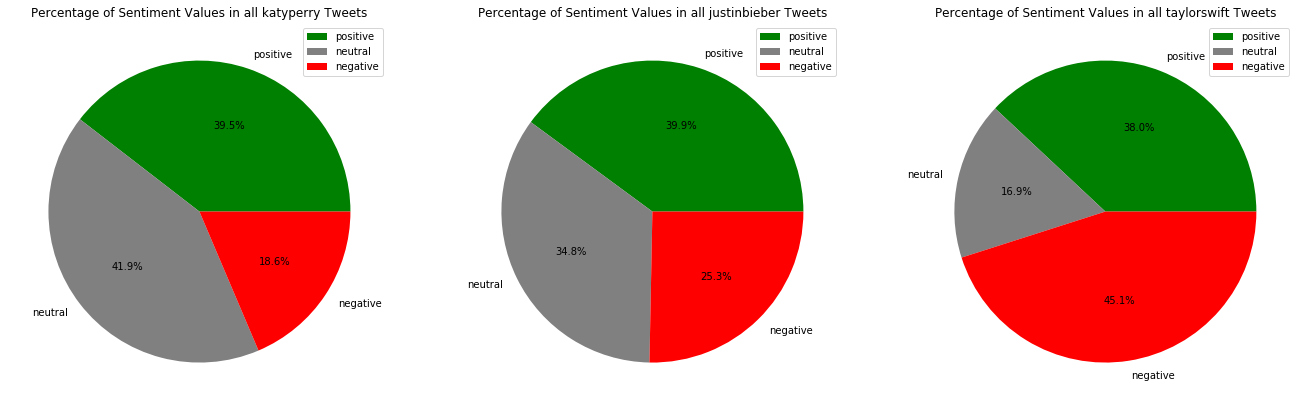

In [28]:
## Pull aggregated back to driver and convert to Pandas dataframe for plotting
brand1SentimentDF = brand1SentimentDF.toPandas()
brand2SentimentDF = brand2SentimentDF.toPandas()
brand3SentimentDF = brand3SentimentDF.toPandas()

import matplotlib.pyplot as plt

# Plot sentiment
%matplotlib inline
plot1_labels = brand1SentimentDF['SENTIMENT_LABEL']
plot1_values = brand1SentimentDF['NUM_TWEETS']
plot1_colors = ['green', 'gray', 'red']

plot2_labels = brand2SentimentDF['SENTIMENT_LABEL']
plot2_values = brand2SentimentDF['NUM_TWEETS']
plot2_colors = ['green', 'gray', 'red']

plot3_labels = brand3SentimentDF['SENTIMENT_LABEL']
plot3_values = brand3SentimentDF['NUM_TWEETS']
plot3_colors = ['green', 'gray', 'red']

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (23, 10))
axes[0].pie(plot1_values,  labels = plot1_labels, colors = plot1_colors, autopct = '%1.1f%%')
axes[0].set_title('Percentage of Sentiment Values in all katyperry Tweets')
axes[0].set_aspect('equal')
axes[0].legend(loc = "upper right", labels=plot1_labels)

axes[1].pie(plot2_values,  labels = plot2_labels, colors = plot2_colors, autopct = '%1.1f%%')
axes[1].set_title('Percentage of Sentiment Values in all justinbieber Tweets')
axes[1].set_aspect('equal')
axes[1].legend(loc = "upper right", labels = plot2_labels)

axes[2].pie(plot3_values,  labels = plot3_labels, colors = plot3_colors, autopct = '%1.1f%%')
axes[2].set_title('Percentage of Sentiment Values in all taylorswift Tweets')
axes[2].set_aspect('equal')
axes[2].legend(loc = "upper right", labels = plot3_labels)

fig.subplots_adjust(hspace = 1)
plt.show()

### 7.2 View sentiment over time for brands<a id="view"> </a>

In [29]:
## Get aggregated sentiment for each day
brand1OverTimeDF = brand1TweetsDF\
                    .groupBy('DAY', 'SENTIMENT_LABEL')\
                    .agg(F.count('TEXT_CLEAN').alias('NUM_TWEETS'))\
                    .orderBy('DAY', ascending = True)

## Get total tweets each day
brand1TweetsPerDayDF = brand1OverTimeDF.groupBy('DAY')\
                        .agg(F.sum('NUM_TWEETS').alias('NUM_TWEETS'))\
                        .orderBy('DAY', ascending = True)
        
## Convert back to Pandas
brand1OverTimeDF = brand1OverTimeDF.toPandas()
brand1TweetsPerDayDF = brand1TweetsPerDayDF.toPandas()

## Identify rows with positive sentiment for each day
positive1Index = brand1OverTimeDF['SENTIMENT_LABEL'] == 'positive'
positive1TweetsDF = brand1OverTimeDF[positive1Index]

## Identify rows with negative sentiment for each day
negative1Index = brand1OverTimeDF['SENTIMENT_LABEL'] == 'negative'
negative1TweetsDF = brand1OverTimeDF[negative1Index]

## Check results
positive1TweetsDF[:2]

,DAY,SENTIMENT_LABEL,NUM_TWEETS
1,2017-07-05,positive,6
4,2017-07-06,positive,5


In [30]:
## Repeat for brand2
## Get aggregated sentiment for each day
brand2OverTimeDF = brand2TweetsDF\
                    .groupBy('DAY', 'SENTIMENT_LABEL')\
                    .agg(F.count('TEXT_CLEAN').alias('NUM_TWEETS'))\
                    .orderBy('DAY', ascending = True)

## Get total tweets each day
brand2TweetsPerDayDF = brand2OverTimeDF.groupBy('DAY')\
                        .agg(F.sum('NUM_TWEETS').alias('NUM_TWEETS'))\
                        .orderBy('DAY', ascending = True)
        
## Convert back to Pandas
brand2OverTimeDF = brand2OverTimeDF.toPandas()
brand2TweetsPerDayDF = brand2TweetsPerDayDF.toPandas()

## Identify rows with positive sentiment for each day
positive2Index = brand2OverTimeDF['SENTIMENT_LABEL'] == 'positive'
positive2TweetsDF = brand2OverTimeDF[positive2Index]

## Identify rows with negative sentiment for each day
negative2Index = brand2OverTimeDF['SENTIMENT_LABEL'] == 'negative'
negative2TweetsDF = brand2OverTimeDF[negative2Index]

In [31]:
## Repeat for brand3
## Get aggregated sentiment for each day
brand3OverTimeDF = brand3TweetsDF\
                    .groupBy('DAY', 'SENTIMENT_LABEL')\
                    .agg(F.count('TEXT_CLEAN').alias('NUM_TWEETS'))\
                    .orderBy('DAY', ascending = True)

## Get total tweets each day
brand3TweetsPerDayDF = brand3OverTimeDF.groupBy('DAY')\
                        .agg(F.sum('NUM_TWEETS').alias('NUM_TWEETS'))\
                        .orderBy('DAY', ascending = True)
        
## Convert back to Pandas
brand3OverTimeDF = brand3OverTimeDF.toPandas()
brand3TweetsPerDayDF = brand3TweetsPerDayDF.toPandas()

## Identify rows with positive sentiment for each day
positive3Index = brand3OverTimeDF['SENTIMENT_LABEL'] == 'positive'
positive3TweetsDF = brand3OverTimeDF[positive3Index]

## Identify rows with negative sentiment for each day
negative3Index = brand3OverTimeDF['SENTIMENT_LABEL'] == 'negative'
negative3TweetsDF = brand3OverTimeDF[negative3Index]

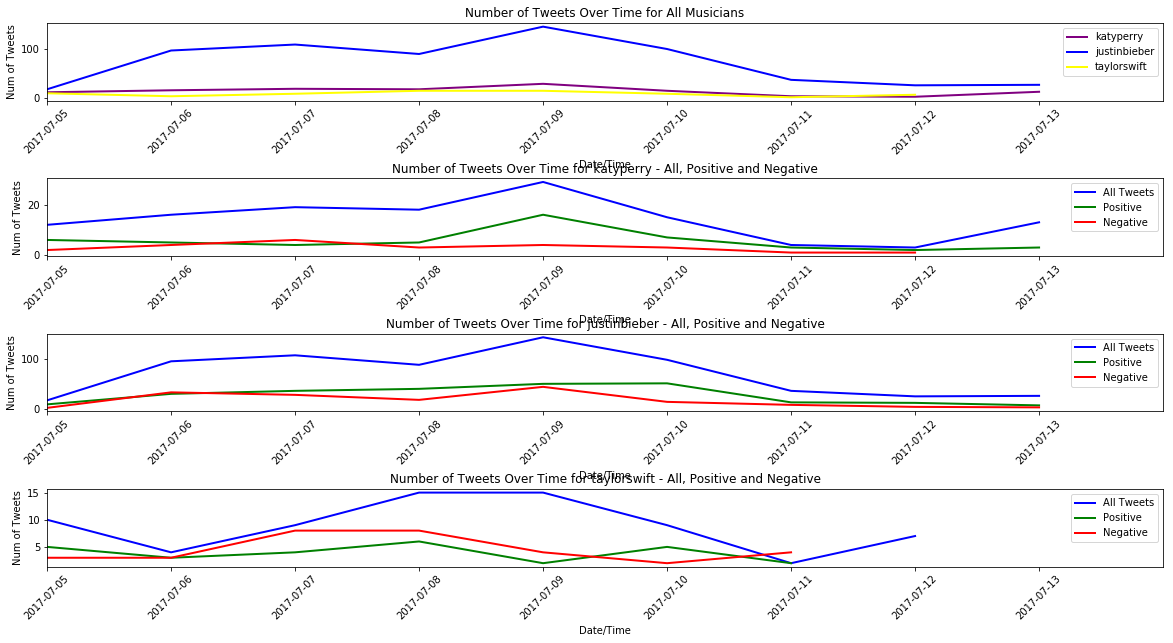

In [32]:
## Define values for matplotlib
x = brand1TweetsPerDayDF['DAY']
y1 = brand1TweetsPerDayDF['NUM_TWEETS']
py1 = positive1TweetsDF['NUM_TWEETS']
ny1 = negative1TweetsDF['NUM_TWEETS']

y2 = brand2TweetsPerDayDF['NUM_TWEETS']
py2 = positive2TweetsDF['NUM_TWEETS']
ny2 = negative2TweetsDF['NUM_TWEETS']

y3 = brand3TweetsPerDayDF['NUM_TWEETS']
py3 = positive3TweetsDF['NUM_TWEETS']
ny3 = negative3TweetsDF['NUM_TWEETS']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))
axes[0].plot(range(len(y1)), y1, linewidth=2, color='purple')
axes[0].plot(range(len(y2)), y2, linewidth=2, color='blue')
axes[0].plot(range(len(y3)), y3, linewidth=2, color='yellow')
axes[0].set_xticks(x.index.tolist())
axes[0].set_xticklabels([date.strftime("%Y-%m-%d") for date in x])
axes[0].margins = 0
axes[0].set_xlabel('Date/Time')
axes[0].set_ylabel('Num of Tweets')
axes[0].set_title('Number of Tweets Over Time for All Musicians')
axes[0].set_xlim(0, len(y1))
axes[0].legend(loc="upper right", labels=['katyperry','justinbieber','taylorswift'])

axes[1].plot(range(len(y1)), y1, linewidth=2, color='blue')
axes[1].plot(range(len(py1)), py1, linewidth=2, color='green')
axes[1].plot(range(len(ny1)), ny1, linewidth=2, color='red')
axes[1].set_xticks(x.index.tolist())
axes[1].set_xticklabels([date for date in x])
axes[1].margins = 0
axes[1].set_xlabel('Date/Time')
axes[1].set_ylabel('Num of Tweets')
axes[1].set_title('Number of Tweets Over Time for katyperry - All, Positive and Negative')
axes[1].set_xlim(0, len(y1))
axes[1].legend(loc="upper right", labels=['All Tweets', 'Positive', 'Negative'])

axes[2].plot(range(len(y2)), y2, linewidth=2, color='blue')
axes[2].plot(range(len(py2)), py2, linewidth=2, color='green')
axes[2].plot(range(len(ny2)), ny2, linewidth=2, color='red')
axes[2].set_xticks(x.index.tolist())
axes[2].set_xticklabels([date for date in x])
axes[2].margins = 0
axes[2].set_xlabel('Date/Time')
axes[2].set_ylabel('Num of Tweets')
axes[2].set_title('Number of Tweets Over Time for justinbieber - All, Positive and Negative')
axes[2].set_xlim(0, len(y1))
axes[2].legend(loc="upper right", labels=['All Tweets', 'Positive', 'Negative'])

axes[3].plot(range(len(y3)), y3, linewidth=2, color='blue')
axes[3].plot(range(len(py3)), py3, linewidth=2, color='green')
axes[3].plot(range(len(ny3)), ny3, linewidth=2, color='red')
axes[3].set_xticks(x.index.tolist())
axes[3].set_xticklabels([date for date in x])
axes[3].margins = 0
axes[3].set_xlabel('Date/Time')
axes[3].set_ylabel('Num of Tweets')
axes[3].set_title('Number of Tweets Over Time for taylorswift - All, Positive and Negative')
axes[3].set_xlim(0, len(y1))
axes[3].legend(loc="upper right", labels=['All Tweets', 'Positive', 'Negative'])

## Rotate x-axes for legibility.
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 45)

fig.subplots_adjust(hspace=1)
plt.show()

### 7.3 Top keywords<a id="keywords"> </a>
Extract and display top keywords expressed in the tweets referring to the brands.

In [33]:
from pyspark.sql.functions import explode

# Explode keywords
brand1KeywordsDF = brand1TweetsDF.select(explode('KEYWORDS').alias('TOPKEYWORDS'))
brand2KeywordsDF = brand2TweetsDF.select(explode('KEYWORDS').alias('TOPKEYWORDS'))
brand3KeywordsDF = brand3TweetsDF.select(explode('KEYWORDS').alias('TOPKEYWORDS'))

brand1TopKeywordsDF = brand1KeywordsDF.select('TOPKEYWORDS').rdd.map(lambda row: row[0]).toDF()
brand2TopKeywordsDF = brand2KeywordsDF.select('TOPKEYWORDS').rdd.map(lambda row: row[0]).toDF()
brand3TopKeywordsDF = brand3KeywordsDF.select('TOPKEYWORDS').rdd.map(lambda row: row[0]).toDF()

In [34]:
# UDF to filter profanity words and other non-insightful words
#filterList = ['the', 'eh', 'beep', <add your own terms here> ]
filterList = ['the', 'eh', 'beep']
def filter_profanity(word):
    if word in filterList:
        return None
    if "http" in word:
        return None
    return word

# UDF to return lower case of word
def toLowerCase(word):
    return word.lower()

In [35]:
# Process extracted keywords to filter profanity and change to lower case
udfLowerCase = udf(toLowerCase, StringType())
brand1TopKeywordsDF = brand1TopKeywordsDF.withColumn('TOPKEYWORDS',udfLowerCase('text'))
brand2TopKeywordsDF = brand2TopKeywordsDF.withColumn('TOPKEYWORDS',udfLowerCase('text'))
brand3TopKeywordsDF = brand3TopKeywordsDF.withColumn('TOPKEYWORDS',udfLowerCase('text'))

udfFilterProfanity = udf(filter_profanity, StringType())
brand1TopKeywordsDF = brand1TopKeywordsDF.withColumn('TOPKEYWORDS',udfFilterProfanity('TOPKEYWORDS'))
brand2TopKeywordsDF = brand2TopKeywordsDF.withColumn('TOPKEYWORDS',udfFilterProfanity('TOPKEYWORDS'))
brand3TopKeywordsDF = brand3TopKeywordsDF.withColumn('TOPKEYWORDS',udfFilterProfanity('TOPKEYWORDS'))

In [36]:
# Group by TOPKEYWORDS and computer average relevance per keyword and also number of tweets for each keyword
brand1KwdsNumDF = brand1TopKeywordsDF.groupBy('TOPKEYWORDS').agg(F.count('TOPKEYWORDS').alias('KWDSNUMTWEETS'))
brand2KwdsNumDF = brand2TopKeywordsDF.groupBy('TOPKEYWORDS').agg(F.count('TOPKEYWORDS').alias('KWDSNUMTWEETS'))
brand3KwdsNumDF = brand3TopKeywordsDF.groupBy('TOPKEYWORDS').agg(F.count('TOPKEYWORDS').alias('KWDSNUMTWEETS'))

brand1KwdsRelDF = brand1TopKeywordsDF.groupBy('TOPKEYWORDS').agg(F.avg('relevance').alias('KWDSAVGRELEVANCE'))
brand2KwdsRelDF = brand2TopKeywordsDF.groupBy('TOPKEYWORDS').agg(F.avg('relevance').alias('KWDSAVGRELEVANCE'))
brand3KwdsRelDF = brand3TopKeywordsDF.groupBy('TOPKEYWORDS').agg(F.avg('relevance').alias('KWDSAVGRELEVANCE'))


In [37]:
# join dataframes into one
brand1TweetsKeywordsDF = brand1KwdsNumDF.join(brand1KwdsRelDF,'TOPKEYWORDS','outer')
brand2TweetsKeywordsDF = brand2KwdsNumDF.join(brand2KwdsRelDF,'TOPKEYWORDS','outer')
brand3TweetsKeywordsDF = brand3KwdsNumDF.join(brand3KwdsRelDF,'TOPKEYWORDS','outer')

# Define keyword score as product of number of tweets expressing that keyword and average relevance
brand1TweetsKeywordsDF = brand1TweetsKeywordsDF.withColumn('KEYWORD_SCORE',brand1TweetsKeywordsDF.KWDSNUMTWEETS * brand1TweetsKeywordsDF.KWDSAVGRELEVANCE)
brand2TweetsKeywordsDF = brand2TweetsKeywordsDF.withColumn('KEYWORD_SCORE',brand2TweetsKeywordsDF.KWDSNUMTWEETS * brand2TweetsKeywordsDF.KWDSAVGRELEVANCE)
brand3TweetsKeywordsDF = brand3TweetsKeywordsDF.withColumn('KEYWORD_SCORE',brand3TweetsKeywordsDF.KWDSNUMTWEETS * brand3TweetsKeywordsDF.KWDSAVGRELEVANCE)

# Sort dataframe in descending order of KEYWORD_SCORE
brand1TweetsKeywordsDF = brand1TweetsKeywordsDF.orderBy('KEYWORD_SCORE',ascending=False)
brand2TweetsKeywordsDF = brand2TweetsKeywordsDF.orderBy('KEYWORD_SCORE',ascending=False)
brand3TweetsKeywordsDF = brand3TweetsKeywordsDF.orderBy('KEYWORD_SCORE',ascending=False)

# Remove None keywords
brand1TweetsKeywordsDF = brand1TweetsKeywordsDF.where(col('TOPKEYWORDS').isNotNull())
brand2TweetsKeywordsDF = brand2TweetsKeywordsDF.where(col('TOPKEYWORDS').isNotNull())
brand3TweetsKeywordsDF = brand3TweetsKeywordsDF.where(col('TOPKEYWORDS').isNotNull())

# Remove the brand name from the list of top keywords
# Note we want to keey one brand name in another brand's list because that could be of interest
brand1TweetsKeywordsDF = brand1TweetsKeywordsDF.where(col('TOPKEYWORDS') != "katy")
brand1TweetsKeywordsDF = brand1TweetsKeywordsDF.where(col('TOPKEYWORDS') != "katy perry")
brand1TweetsKeywordsDF = brand1TweetsKeywordsDF.where(col('TOPKEYWORDS') != "katyperry")

brand2TweetsKeywordsDF = brand2TweetsKeywordsDF.where(col('TOPKEYWORDS') != "justin")
brand2TweetsKeywordsDF = brand2TweetsKeywordsDF.where(col('TOPKEYWORDS') != "justin bieber")
brand2TweetsKeywordsDF = brand2TweetsKeywordsDF.where(col('TOPKEYWORDS') != "justinbieber")

brand3TweetsKeywordsDF = brand3TweetsKeywordsDF.where(col('TOPKEYWORDS') != "taylor")
brand3TweetsKeywordsDF = brand3TweetsKeywordsDF.where(col('TOPKEYWORDS') != "taylor swift")
brand3TweetsKeywordsDF = brand3TweetsKeywordsDF.where(col('TOPKEYWORDS') != "taylorswift")

In [38]:
print "Top Keywords from tweets mentioning katyperry"
brand1TweetsKeywordsDF.show()

Top Keywords from tweets mentioning katyperry
+--------------------+-------------+------------------+------------------+
|         TOPKEYWORDS|KWDSNUMTWEETS|  KWDSAVGRELEVANCE|     KEYWORD_SCORE|
+--------------------+-------------+------------------+------------------+
|        amazing book|            6|0.9421960016091665| 5.653176009654999|
|            best way|            6|0.7752991815408071|4.6517950892448425|
|         swish swish|            4|0.9559377431869507|3.8237509727478027|
|               swish|            4| 0.840412512421608| 3.361650049686432|
|             witness|            4|0.7816360145807266|3.1265440583229065|
|               feels|            4|0.7377842664718628| 2.951137065887451|
|              living|            4|0.6123327612876892| 2.449331045150757|
|                tour|            3|0.7978049914042155|2.3934149742126465|
|                  ft|            3|0.7495850125948588|2.2487550377845764|
|                vote|            3|  0.71247465411822

In [39]:
print "Top Keywords from tweets mentioning justinbieber"
brand2TweetsKeywordsDF.show()

Top Keywords from tweets mentioning justinbieber
+--------------------+-------------+-------------------+------------------+
|         TOPKEYWORDS|KWDSNUMTWEETS|   KWDSAVGRELEVANCE|     KEYWORD_SCORE|
+--------------------+-------------+-------------------+------------------+
|              social|           64| 0.9555700933560729|61.156485974788666|
|              follow|           29| 0.9190473494858578|26.652373135089874|
|                 amp|           32|  0.682481431402266|21.839405804872513|
|       vip packages…|           11| 0.9964770078659058|10.961247086524963|
|           despacito|           17| 0.6383479342741125|10.851914882659912|
|                vote|           12| 0.9036555687586466| 10.84386682510376|
|purpose tour  lau...|           11| 0.9568899869918823|10.525789856910706|
|               spree|           10| 0.9667449951171875| 9.667449951171875|
|       bkstg presale|           11| 0.8304200172424316| 9.134620189666748|
|                guys|            9| 0.

In [40]:
print "Top Keywords from tweets mentioning taylorsiwft"
brand3TweetsKeywordsDF.show()

Top Keywords from tweets mentioning taylorsiwft
+--------------------+-------------+------------------+------------------+
|         TOPKEYWORDS|KWDSNUMTWEETS|  KWDSAVGRELEVANCE|     KEYWORD_SCORE|
+--------------------+-------------+------------------+------------------+
|                kiss|            3|  0.96131831407547|  2.88395494222641|
|        live forever|            3|0.8712899883588155|2.6138699650764465|
|                love|            3|0.7883326808611552|2.3649980425834656|
|               album|            3|0.7207663208246231|2.1622989624738693|
|             release|            2|0.9826980233192444|1.9653960466384888|
|flameless plasma ...|            2|0.9699360132217407|1.9398720264434814|
|             grandma|            2|0.9681810140609741|1.9363620281219482|
|            dont wan|            2|0.9671800136566162|1.9343600273132324|
|  lighter double arc|            2|0.8200799822807312|1.6401599645614624|
|              quatro|            2|0.74063897132873

In [41]:
brand1TweetsKeywordsPandas = brand1TweetsKeywordsDF.toPandas()
brand2TweetsKeywordsPandas = brand2TweetsKeywordsDF.toPandas()
brand3TweetsKeywordsPandas = brand3TweetsKeywordsDF.toPandas()

In [42]:
from wordcloud import WordCloud

# Process Pandas DataFrame in the right format to leverage wordcloud.py for plotting
# See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py 
def prepForWordCloud(pandasDF,n):
    kwdList = pandasDF['TOPKEYWORDS']
    sizeList = pandasDF['KEYWORD_SCORE']
    kwdSize = {}
    for i in range(n):
        kwd=kwdList[i]
        size=sizeList[i]
        kwdSize[kwd] = size
    return kwdSize

/gpfs/fs01/user/s867-a5b1d2097d064e-155f8ab1ea9e/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


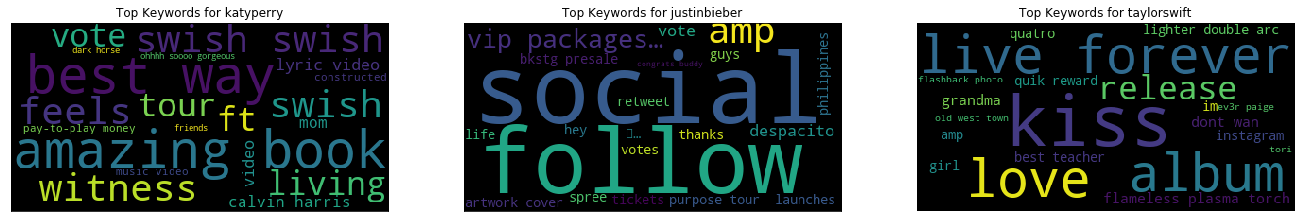

In [43]:
%matplotlib inline
maxWords = len(brand1TweetsKeywordsPandas)
nWords = 20

#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
brand1KwdFreq = prepForWordCloud(brand1TweetsKeywordsPandas,nWords)
brand1WordCloud = WordCloud(max_words=maxWords,relative_scaling=0,normalize_plurals=False).generate_from_frequencies(brand1KwdFreq)

brand2KwdFreq = prepForWordCloud(brand2TweetsKeywordsPandas,nWords)
brand2WordCloud = WordCloud(max_words=nWords,relative_scaling=0,normalize_plurals=False).generate_from_frequencies(brand2KwdFreq)

brand3KwdFreq = prepForWordCloud(brand3TweetsKeywordsPandas,nWords)
brand3WordCloud = WordCloud(max_words=nWords,relative_scaling=0,normalize_plurals=False).generate_from_frequencies(brand3KwdFreq)


fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (23, 10))

# Set titles for images
ax[0].set_title('Top Keywords for katyperry')
ax[1].set_title('Top Keywords for justinbieber')
ax[2].set_title('Top Keywords for taylorswift')

                
# Plot word clouds
ax[0].imshow(brand1WordCloud)
ax[1].imshow(brand2WordCloud)
ax[2].imshow(brand3WordCloud)

# turn off axis and ticks
plt.axis("off")
ax[0].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 

ax[1].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 

ax[2].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 

plt.show()

_____________

<a id="enrichpi"> </a>
## Step 8: Enrich the data with <a href="https://www.ibm.com/watson/developercloud/personality-insights.html" target="_blank" rel="noopener no referrer">Watson Personality Insights (PI)</a>

In this tutorial, we will create personality profiles for a sample of 100 users as that is the limit of what we can run with free plan for Watson <a href="https://www.ibm.com/watson/developercloud/personality-insights.html" target="_blank" rel="noopener no referrer">Personality Insights (PI)</a>. 

In practice, you can run personality profiles for all users, or you can choose to run personality profiles for only a selected subset of users; for example, for users with most negative sentiment tweets or users with largest number of followers or posts.

In [44]:
import random
## Aggregate users by sentiment
brandUserSentimentDF = brand2TweetsDF\
                        .groupBy('USER_SCREEN_NAME', 'SENTIMENT_LABEL','SENTIMENT',\
                                 'USER_FAVOURITES_COUNT','USER_STATUSES_COUNT',
                                 'USER_FOLLOWERS_COUNT','USER_FRIENDS_COUNT')\
                        .count()\
                        .orderBy('SENTIMENT', ascending = True)

## Get negative and positive tweeting users
negativeTweetersDF = brandUserSentimentDF.where(col('SENTIMENT_LABEL') == "negative")
positiveTweetersDF = brandUserSentimentDF.where(col('SENTIMENT_LABEL') == "positive")  

# Take a random sample of 100 users
num_users = brandUserSentimentDF.count()
sample_num_users = 95
usrfraction = float(sample_num_users)/float(num_users)
usrseed = random.randint(1, 100)

## Start off by finding the number of unique users tweeting about Coke
print 'Number of unique users tweeting about justinbieber: ', len(brand2TweetsDF.select('USER_SCREEN_NAME').distinct().collect())
print 'Number of negative tweeting folks: ', negativeTweetersDF.count()
print 'Number of positive tweeting folks: ', positiveTweetersDF.count()
print 'Sample size: ', sample_num_users, ' Fraction: ', usrfraction, ' Seed: ', usrseed

brandUserSampleDF = brandUserSentimentDF.sample(False, usrfraction, usrseed)

print 'Records in brandUserSampleDF: ', brandUserSampleDF.count()

Number of unique users tweeting about justinbieber:  615
Number of negative tweeting folks:  161
Number of positive tweeting folks:  257
Sample size:  95  Fraction:  0.147975077882  Seed:  92
Records in brandUserSampleDF:  100


In this step, we collect enough tweets for each unique user and run those tweets through Personality Insights to extract the Big Five personality traits, also known as OCEAN (openness, conscientiousness, extraversion, agreeableness, and neuroticism).

In [45]:
## Libraries and Credentials for Twitter and Personality Insights
import urllib2, requests, json
import tweepy
from tweepy import OAuthHandler
from watson_developer_cloud import PersonalityInsightsV3

## Credentials for Twitter Developer account
consumer_key = credentials_json['twitter_consumer_key']
consumer_secret = credentials_json['twitter_consumer_secret']
access_token = credentials_json['twitter_access_token']
access_token_secret = credentials_json['twitter_access_token_secret'] 

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
 
api = tweepy.API(auth)

## Get PI object using PI credentials
personality_insights = PersonalityInsightsV3(
  version=credentials_json['pi_version'],
  username=credentials_json['pi_username'],
  password=credentials_json['pi_password'])

Now we'll define several functions to programmatically paint a portrait of each user and their personality.

- `getTweets()` - to collect tweets from a given user ID
- `getPersonality()` - to call Personality Insights on the users' tweets
- `extractOCEANtraits()` - to gather the OCEAN scores for each users PI data
- `getPItraits()` - to put it all together and return a list of traits for each user

In [46]:
## Collect tweets for a given user
def getTweets(username):
    twitter_id = username    
    try:
        tweet_collection = api.user_timeline(screen_name = twitter_id, count = 100, include_rts = True)
        i = 0
        tweets = []
        for status in tweet_collection:
            i = i+1
            tweets.append(status.text)
    except Exception:
        tweets = None
    return tweets

## Call Personality Insights on the tweets for the user
def getPersonality(tweets):
    # get tweets by user
    if tweets == None:
        profile = None
    else:
        tweets_content = ' '.join(tweets)
        # UTF-8 encoding
        twt = tweets_content.encode('utf-8')
        # call PI to get personality profile
        try:
            profile = personality_insights.profile(twt, content_type = 'text/plain', content_language = None,
                                           accept ='application/json', accept_language = None, raw_scores = False,
                                           consumption_preferences = False, csv_headers = False)
        except Exception:
            profile = None
    
    return profile


## Extract OCEAN percentiles from PI data
def extractOCEANtraits(profile):
    if profile == None:
        openness = None
        conscientiousness = None
        extraversion = None
        agreeableness = None
        neuroticism = None
    else:
        personality = profile['personality']
        openness = personality[0]['percentile']
        conscientiousness = personality[1]['percentile']
        extraversion = personality[2]['percentile']
        agreeableness = personality[3]['percentile']
        neuroticism = personality[4]['percentile']
    
    return openness, conscientiousness, extraversion, agreeableness, neuroticism

## Combine function calls for a user
def getPItraits(user, verbose = F):
    # get tweets by user
    if verbose == F:
        try:
            tweets = getTweets(user)
            # run PI profile on extracted tweets
            profile = getPersonality(tweets)
            # extract OCEAN traits
            openness, conscientiousness, extraversion, agreeableness, neuroticism = extractOCEANtraits(profile)
        except Exception:
            return None
        return openness, conscientiousness, extraversion, agreeableness, neuroticism
    else:
        print 'Getting tweets for user: ', user
        try:
            tweets = getTweets(user)
            # run PI profile on extracted tweets
            profile = getPersonality(tweets)
            # extract OCEAN traits
            openness, conscientiousness, extraversion, agreeableness, neuroticism = extractOCEANtraits(profile)
        except Exception:
            return None
        return openness, conscientiousness, extraversion, agreeableness, neuroticism

Now we'll extract Personality Insights traits for the users sampled in step 7, then push the data back to Spark for machine learning.  

**This cell will also send data to the API, so be mindful of the number of calls you are making and be patient for the results.**

In [47]:
## Convert to Pandas to use the Watson PI API
brandUserSampleDF = brandUserSampleDF.toPandas()
brandUserSampleDF['OPENNESS'], brandUserSampleDF['CONSCIENTIOUSNESS'],\
brandUserSampleDF['EXTRAVERSION'], brandUserSampleDF['AGREEABLENESS'],\
brandUserSampleDF['NEUROTICISM'] = zip(*brandUserSampleDF['USER_SCREEN_NAME'].map(getPItraits))

# Conver back to Spark Dataframe from Pandas dataframe
userPersonalityDF = spark.createDataFrame(brandUserSampleDF)

## Drop rows without any PI enrichment
userPersonalityDF = userPersonalityDF.na.drop()

## Check row count and schema
print 'Number of records in userPersonalityInsightsDF: ', userPersonalityDF.count()
userPersonalityDF.printSchema()

userPersonalityDF.limit(2).toPandas()

Number of records in userPersonalityInsightsDF:  69
root
 |-- USER_SCREEN_NAME: string (nullable = true)
 |-- SENTIMENT_LABEL: string (nullable = true)
 |-- SENTIMENT: double (nullable = true)
 |-- USER_FAVOURITES_COUNT: long (nullable = true)
 |-- USER_STATUSES_COUNT: long (nullable = true)
 |-- USER_FOLLOWERS_COUNT: long (nullable = true)
 |-- USER_FRIENDS_COUNT: long (nullable = true)
 |-- count: long (nullable = true)
 |-- OPENNESS: double (nullable = true)
 |-- CONSCIENTIOUSNESS: double (nullable = true)
 |-- EXTRAVERSION: double (nullable = true)
 |-- AGREEABLENESS: double (nullable = true)
 |-- NEUROTICISM: double (nullable = true)



,USER_SCREEN_NAME,SENTIMENT_LABEL,SENTIMENT,USER_FAVOURITES_COUNT,USER_STATUSES_COUNT,USER_FOLLOWERS_COUNT,USER_FRIENDS_COUNT,count,OPENNESS,CONSCIENTIOUSNESS,EXTRAVERSION,AGREEABLENESS,NEUROTICISM
0,bieberxdolan_,negative,-0.833627,2988,1904,225,120,1,0.196833,0.488974,0.12149,0.812868,0.085776
1,yedek219232,negative,-0.774503,17,23,19,425,1,0.053619,0.288436,0.01592,0.232715,0.030674


________________

<a id="sparkml"> </a>
## Step 9: Spark machine learning for user segmentation 
<a href="https://spark.apache.org/docs/latest/ml-guide.html" target="_blank" rel="noopener no referrer">Spark MLlib</a>  includes a rich set of machine learning algorithms that are very powerful in extracting insights from data. Typically, you will need to convert the data into the right format before you can apply these machine learning algorithms. In this step, we apply several steps to process the data so it can run the <a href="https://spark.apache.org/docs/latest/mllib-clustering.html#k-means" target="_blank" rel="noopener no referrer">Kmeans</a> clustering algorithm including normalizing **USER_FOLLOWERS_COUNT** and **USER_STATUSES_COUNT** fields as well as extracting the relevant feature set into a Vector to be used for clustering.

We run Kmeans clustering using two different feature sets.
* **FeatureSet 1** (no Personality Traits): (SENTIMENT, USER_FOLLOWERS_COUNT, USER_STATUSES_COUNT)
* **FeatureSet 2** (with Personality Traits): (SENTIMENT, USER_FOLLOWERS_COUNT, USER_STATUSES_COUNT, OPENNESS, CONSCIENTIOUSNESS, EXTRAVERSION, AGREEABLENESS, NEUROTICISM)

First, we'll convert the follower and statuses counts to a vector as per the Spark documentation. Then we can run <a href="https://spark.apache.org/docs/2.1.0/ml-features.html#minmaxscaler" target="_blank" rel="noopener no referrer">MinMaxScaler</a> and normalize the counts to a range between 0 and 1. These are necessary preprocessing steps for the clustering algorithm to work properly.

In [48]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors

## Define columns to be converted to vectors
followersVector = VectorAssembler(
  inputCols=["USER_FOLLOWERS_COUNT"], outputCol="USER_FOLLOWERS_COUNT_VECTOR")

statusesVector = VectorAssembler(
  inputCols=["USER_STATUSES_COUNT"], outputCol="USER_STATUSES_COUNT_VECTOR")

## Define our input and output columns for MinMaxScaler
followersScaler = MinMaxScaler(inputCol="USER_FOLLOWERS_COUNT_VECTOR", outputCol="USER_FOLLOWERS_COUNT_SCALED")
statusesScaler = MinMaxScaler(inputCol="USER_STATUSES_COUNT_VECTOR", outputCol="USER_STATUSES_COUNT_SCALED")

## Invoke the VectorAssembler transformations and select desired columns
userPersonalityDF = followersVector.transform(userPersonalityDF)
userPersonalityDF = statusesVector.transform(userPersonalityDF)

## Fit MinMaxScalerModel on our vectors and rescale
followersScalerModel = followersScaler.fit(userPersonalityDF)
statusesScalerModel = statusesScaler.fit(userPersonalityDF)

userPersonalityDF = followersScalerModel.transform(userPersonalityDF)
userPersonalityDF = statusesScalerModel.transform(userPersonalityDF)

## User-defined function to convert from vector back to float
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, udf

def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None

udfVecToFloat = udf(ith_, DoubleType())

## Add column for floating point scaled followers
userPersonalityDF = userPersonalityDF.withColumn("SCALED_FOLLOWERS", udfVecToFloat('USER_FOLLOWERS_COUNT_SCALED', lit(0)))\
                                     .withColumn("SCALED_STATUSES", udfVecToFloat('USER_STATUSES_COUNT_SCALED', lit(0)))\
                                     .select("USER_SCREEN_NAME", "SENTIMENT_LABEL", "SENTIMENT", "SCALED_FOLLOWERS", \
                                            "SCALED_STATUSES", "OPENNESS", "CONSCIENTIOUSNESS", "EXTRAVERSION", \
                                            "AGREEABLENESS", "NEUROTICISM")
        
## Lastly, we'll have to add columns for features both with and without Personality Insights
assemblerWithPI = VectorAssembler(
    inputCols = ['SENTIMENT','SCALED_FOLLOWERS','SCALED_STATUSES','OPENNESS','CONSCIENTIOUSNESS','EXTRAVERSION',\
               'AGREEABLENESS','NEUROTICISM'],
    outputCol = "PI_ENRICHED_FEATURES")

assemblerWithoutPI = VectorAssembler(
    inputCols = ['SENTIMENT', 'SCALED_FOLLOWERS', 'SCALED_STATUSES'],
    outputCol = "BASE_FEATURES")


userPersonalityDF = assemblerWithPI.transform(userPersonalityDF)
userPersonalityDF = assemblerWithoutPI.transform(userPersonalityDF)

## View transformed DF
userPersonalityDF.limit(5).toPandas()

,USER_SCREEN_NAME,SENTIMENT_LABEL,SENTIMENT,SCALED_FOLLOWERS,SCALED_STATUSES,OPENNESS,CONSCIENTIOUSNESS,EXTRAVERSION,AGREEABLENESS,NEUROTICISM,PI_ENRICHED_FEATURES,BASE_FEATURES
0,bieberxdolan_,negative,-0.833627,0.000732,0.004428,0.196833,0.488974,0.121490,0.812868,0.085776,"[-0.8336269855499268, 0.000731821552632606, 0....","[-0.8336269855499268, 0.000731821552632606, 0...."
1,yedek219232,negative,-0.774503,0.000062,0.000044,0.053619,0.288436,0.015920,0.232715,0.030674,"[-0.7745029926300049, 6.179826444453118e-05, 4...","[-0.7745029926300049, 6.179826444453118e-05, 4..."
2,Belieber122003,negative,-0.716680,0.004794,0.002021,0.096360,0.842433,0.196683,0.773335,0.667473,"[-0.7166799902915955, 0.00479424430480205, 0.0...","[-0.7166799902915955, 0.00479424430480205, 0.0..."
3,MiichelleNavy,negative,-0.664037,0.006703,0.280002,0.071917,0.433850,0.349907,0.263957,0.120631,"[-0.6640369892120361, 0.006703485422114672, 0....","[-0.6640369892120361, 0.006703485422114672, 0...."
4,lghayden,negative,-0.661866,0.005185,0.001501,0.067228,0.396212,0.137845,0.722892,0.164761,"[-0.6618660092353821, 0.005184549132872774, 0....","[-0.6618660092353821, 0.005184549132872774, 0...."


### Kmeans clustering 

Now that we have prepared the data, we can run Kmeans to assign cluster labels to each user.

In [49]:
from pyspark.ml.clustering import KMeans

## Define model parameters and set the seed
baseKMeans = KMeans(featuresCol = "BASE_FEATURES", predictionCol = "BASE_PREDICTIONS").setK(5).setSeed(206)
piKMeans = KMeans(featuresCol = "PI_ENRICHED_FEATURES", predictionCol = "PI_PREDICTIONS").setK(5).setSeed(206)

## Fit model on our feature vectors
baseClustersFit = baseKMeans.fit(userPersonalityDF.select("BASE_FEATURES"))
enrichedClustersFit = piKMeans.fit(userPersonalityDF.select("PI_ENRICHED_FEATURES"))

## Get the cluster IDs for each user
userPersonalityDF = baseClustersFit.transform(userPersonalityDF)
userPersonalityDF = enrichedClustersFit.transform(userPersonalityDF)

## Check our work
userPersonalityDF.limit(5).toPandas()

,USER_SCREEN_NAME,SENTIMENT_LABEL,SENTIMENT,SCALED_FOLLOWERS,SCALED_STATUSES,OPENNESS,CONSCIENTIOUSNESS,EXTRAVERSION,AGREEABLENESS,NEUROTICISM,PI_ENRICHED_FEATURES,BASE_FEATURES,BASE_PREDICTIONS,PI_PREDICTIONS
0,bieberxdolan_,negative,-0.833627,0.000732,0.004428,0.196833,0.488974,0.121490,0.812868,0.085776,"[-0.8336269855499268, 0.000731821552632606, 0....","[-0.8336269855499268, 0.000731821552632606, 0....",2,1
1,yedek219232,negative,-0.774503,0.000062,0.000044,0.053619,0.288436,0.015920,0.232715,0.030674,"[-0.7745029926300049, 6.179826444453118e-05, 4...","[-0.7745029926300049, 6.179826444453118e-05, 4...",2,1
2,Belieber122003,negative,-0.716680,0.004794,0.002021,0.096360,0.842433,0.196683,0.773335,0.667473,"[-0.7166799902915955, 0.00479424430480205, 0.0...","[-0.7166799902915955, 0.00479424430480205, 0.0...",2,1
3,MiichelleNavy,negative,-0.664037,0.006703,0.280002,0.071917,0.433850,0.349907,0.263957,0.120631,"[-0.6640369892120361, 0.006703485422114672, 0....","[-0.6640369892120361, 0.006703485422114672, 0....",2,1
4,lghayden,negative,-0.661866,0.005185,0.001501,0.067228,0.396212,0.137845,0.722892,0.164761,"[-0.6618660092353821, 0.005184549132872774, 0....","[-0.6618660092353821, 0.005184549132872774, 0....",2,1


____________

<a id="clusters"> </a>
## Step 10: Visualize user clusters

OK, great - we have successfully clustered our users both with and without enrichment data from Watson Personality Insights. Now we can visualize users through their cluster identity.
 
In this step, we visualize the different user clusters obtained with and without using Personality traits. This visualization illustrates the differences between two clustering approachs and shows how Watson <a href="https://www.ibm.com/watson/developercloud/personality-insights.html" target="_blank" rel="noopener no referrer">Personality Insights</a> can help provide finer user segmentation.

Brand managers and marketing teams can use this segmentation to craft different messaging to target the various user segments to improve brand adoption in the marketplace.

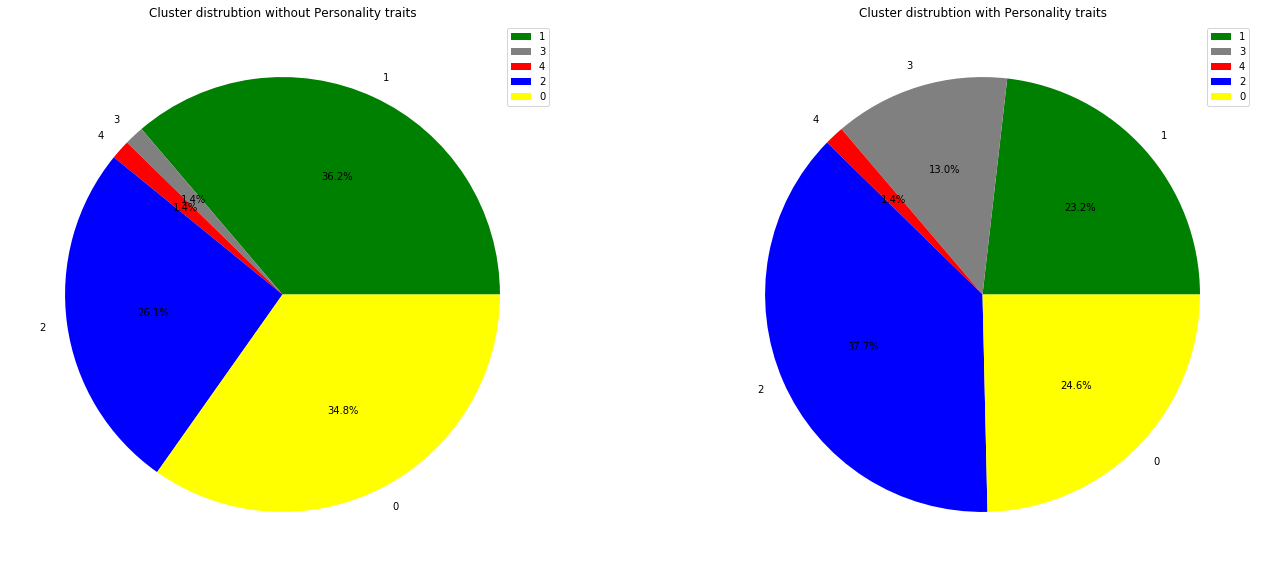

In [50]:
## Aggregate users in each cluster and convert to Pandas for plotting
baseClusterAggDF = userPersonalityDF.groupBy('BASE_PREDICTIONS').agg(F.count('USER_SCREEN_NAME').alias('NUM_USERS')).toPandas()
enrichedClusterAggDF = userPersonalityDF.groupBy('PI_PREDICTIONS').agg(F.count('USER_SCREEN_NAME').alias('NUM_USERS')).toPandas()

%matplotlib inline
# Code courtesy of 
#pandas_softdrink_tweets_grouped_by_sentiment=df_softdrink_tweets_grouped_by_sentiment.toPandas()
#pandas_softdrink_tweets_grouped_by_sentiment.count()
plot1_labels = baseClusterAggDF['BASE_PREDICTIONS']
plot1_values = baseClusterAggDF['NUM_USERS']
plot1_colors = ['green', 'gray', 'red', 'blue', 'yellow']
plot2_labels = enrichedClusterAggDF['PI_PREDICTIONS']
plot2_values = enrichedClusterAggDF['NUM_USERS']
plot2_colors = ['green', 'gray', 'red', 'blue', 'yellow']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))
axes[0].pie(plot1_values,  labels=plot1_labels, colors=plot1_colors, autopct='%1.1f%%')
axes[0].set_title('Cluster distrubtion without Personality traits')
axes[0].set_aspect('equal')
axes[0].legend(loc="upper right", labels=plot1_labels)
axes[1].pie(plot2_values,  labels=plot2_labels, colors=plot2_colors, autopct='%1.1f%%')
axes[1].set_title('Cluster distrubtion with Personality traits')
axes[1].set_aspect('equal')
axes[1].legend(loc="upper right", labels=plot2_labels)
fig.subplots_adjust(hspace=1)
plt.show()

### Scatter plots of clusters using Principal Components Analysis (PCA)

Typically you would visualize clusters by plotting some aggregate measure of the data, then filling in the data points with different colors based on cluster ID. In the absence of aggregate metrics, we can use Principal Components Analysis (PCA) to compress our data set down to two dimensions. After we've performed PCA we can then plot the values of the two components on the X and Y axis to form a scatterplot.  

Let's try that now.

In [51]:
from pyspark.ml.feature import PCA

## Get the first two principal components for features with and without enrichment from Personality Insights
pcaBase = PCA(k = 2, inputCol = "BASE_FEATURES", outputCol = "pcaFeaturesBase")
pcaEnriched = PCA(k = 2, inputCol = "PI_ENRICHED_FEATURES", outputCol = "pcaFeaturesEnriched")

## Fit the model to our data
pcaBaseModel = pcaBase.fit(userPersonalityDF)
pcaEnrichedModel = pcaEnriched.fit(userPersonalityDF)

## Transform the data get our principal components
userPersonalityDF = pcaBaseModel.transform(userPersonalityDF)
userPersonalityDF = pcaEnrichedModel.transform(userPersonalityDF)

We have the principal components, but before we can plot them we have to convert them from a feature vector back to individual columns.  We'll accomplish this using a lambda function to build a RowRDD, then convert back to a DataFrame.

In [52]:
from pyspark.sql import Row

## Split the features vector into columns with the rdd-based API, then convert to DF and reorder columns
pcaDF = userPersonalityDF.select("pcaFeaturesBase", "pcaFeaturesEnriched", "USER_SCREEN_NAME", "BASE_PREDICTIONS", "PI_PREDICTIONS")\
                         .rdd.map(lambda x: Row(**{'PC1_BASE': float(x[0][0]), 
                                                   'PC2_BASE': float(x[0][1]),
                                                   'PC1_ENRICHED': float(x[1][0]),
                                                   'PC2_ENRICHED': float(x[1][1]),
                                                   'USER_SCREEN_NAME': str(x[2]),
                                                   'BASE_PREDICTIONS': int(x[3]),
                                                   'PI_PREDICTIONS': int(x[4])}))\
                         .toDF()\
                         .select("USER_SCREEN_NAME", "PC1_BASE", "PC2_BASE", "BASE_PREDICTIONS",\
                                 "PC1_ENRICHED", "PC2_ENRICHED", "PI_PREDICTIONS")
pcaDF.limit(5).toPandas()

,USER_SCREEN_NAME,PC1_BASE,PC2_BASE,BASE_PREDICTIONS,PC1_ENRICHED,PC2_ENRICHED,PI_PREDICTIONS
0,bieberxdolan_,0.832720,-0.031373,2,0.879640,0.909894,1
1,yedek219232,0.773825,-0.025325,2,0.794447,0.311278,1
2,Belieber122003,0.716000,-0.027533,2,0.785497,1.183055,1
3,MiichelleNavy,0.651922,-0.266588,2,0.663461,0.570618,1
4,lghayden,0.661257,-0.025494,2,0.703264,0.790635,1


Now that the dimensionality of our dataset has been reduced to 2, we can view the components on a typical scatter plot.  Let's see how the clusters look from this perspective.

In [53]:
import plotly 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

pcaDF = pcaDF.toPandas()

## For Base Features
data = [go.Scatter(x = pcaDF.PC2_BASE, 
                   y = pcaDF.PC1_BASE, 
                   mode = 'markers',
                   name = 'BASE_PREDICTIONS',
                   marker = dict(color = pcaDF.BASE_PREDICTIONS, size = '12'),
                   text = pcaDF.BASE_PREDICTIONS
                                 )
       ]

plotly.offline.iplot(data)

What is interesting to note about the clustering without Personality Insights enrichment is that it appears to have a very clear stratification from -1 to 1.  These clusters appear to be somewhat intuitively grouped together.  What about when we run the same algorithm on the PI-enriched data?

In [54]:
## For Enriched Features
data = [go.Scatter(x = pcaDF.PC2_ENRICHED, 
                   y = pcaDF.PC1_ENRICHED, 
                   mode = 'markers',
                   name = 'Clusters with PI',
                   marker = dict(color = pcaDF.PI_PREDICTIONS, size = '12'),
                   text = pcaDF.PI_PREDICTIONS
                                 )
       ]

plotly.offline.iplot(data)

Not quite the same intuitive results.  Perhaps we should iterate over this and try a different clustering algorithm some time.

**At this point you may be wondering what the utility of all this work might be.**  Well, now that we've enriched the user data with Watson APIs and grouped them into clusters, we can track these clusters over time to see how they respond to various metrics.  This could be purchase history, click patterns, or the response to different advertisement campaigns.  As we build up this data set we'll be able to classify new users and what group they fall into, resulting in a stronger user segmentation model over time.

_______

## Summary
We've accomplished quite a lot in this notebook, so let's take a moment to review.

First we loaded our tweet data from Db2 Warehouse on Cloud. Then we enriched it with several Watson APIs - Natural Language Understanding and Personality Insights. Using Spark and its elegant API we shaped our data, explored it visually, and prepared it for machine learning. Our approach was to discover user segmentation by assigning cluster IDs to each data point. Finally, we plotted the results of our clustering with the aid of principal components analysis.  

While more work remains to be done - no one said data science was easy - we have seen how we can seamlessly move between Watson APIs, Spark, and Python using the Watson Studio. 
_______

### Authors
**Rafi Kurlansik** is an Open Source Solutions Engineer specializing in big data technologies, such as Hadoop and Spark. He's responsible for developing and delivering demonstrations of IBM tech to both enterprise clients and the larger analytics community. Kurlansik has hands-on experience with machine learning, natural language processing, data visualization, and dashboard development. If you're wondering where he comes down on the biggest data science debate of our day, Rafi is, in his own words, "an avid R fan, especially RStudio!"

**Joseph Kozhaya** is an IBM Master Inventor and a Watson Solution Architect working closely with partners, clients, and universities to build cloud and cognitive solutions.

Copyright © IBM Corp. 2017, 2018. This notebook and its source code are released under the terms of the MIT License.

<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>